# Diffraction pattern of a full or empty virus.
We have implemented a grid/mask approach to account for the contribution of the inner void in a virus.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skopi as sk

## Inputs and parameters

In [3]:
input_dir='../input'
pdbfile=input_dir+'/pdb/1fpv.pdb'
beamfile=input_dir+'/beam/amo86615.beam'
geom=input_dir+'/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data'

## Definition of the beam, the detector and the hydrated particle

### Beam
We illustrate below how to define the beam, retrieve its flux and change it eventually

In [4]:
beam = sk.Beam(beamfile)

In [5]:
increase_factor = 1e2
print('BEFORE: # of photons per pulse {}'.format(beam.get_photons_per_pulse()))
print('>>> Increasing the number of photons per pulse by a factor {}'.format(increase_factor))
beam.set_photons_per_pulse(increase_factor * beam.get_photons_per_pulse())
print('AFTER : # of photons per pulse {}'.format(beam.get_photons_per_pulse()))

BEFORE: # of photons per pulse 1e+12
>>> Increasing the number of photons per pulse by a factor 100.0
AFTER : # of photons per pulse 1e+14


### Detector
We illustrate below how to define the detector, and change its distance to the sample

In [6]:
det = sk.PnccdDetector(geom=geom, beam=beam)

In [7]:
det.distance

-0.5810000000000015

Depending on the psana version, the sign of the detector distance might need to be flipped.

In [8]:
factor = -1
print('BEFORE: Detector distance {} m'.format(det.distance))
print('>>> Increasing the distance by a factor {}'.format(increase_factor))
det.distance = factor * det.distance
print('AFTER : Detector distance {} m'.format(det.distance))

BEFORE: Detector distance -0.581 m
>>> Increasing the distance by a factor 100.0
AFTER : Detector distance 0.581 m


### Particle
We illustrate below how to build a particle from a PDB file and then hydrate it

In [9]:
particle = sk.Particle()
particle.read_pdb(pdbfile, ff='WK')
print('Number of atoms in particle: {}'.format(particle.get_num_atoms()))

no symmetry REMARK 350 found
Number of atoms in particle: 261000


In [10]:
hydration_layer_thickness = 10.0 / 10**10
mesh_voxel_size           = 5.0 / 10**10
print('Hydration layer: [ {} m (thickness) ] [ {} m (mesh voxel size) ]'.format(hydration_layer_thickness,mesh_voxel_size))

Hydration layer: [ 1e-09 m (thickness) ] [ 5e-10 m (mesh voxel size) ]


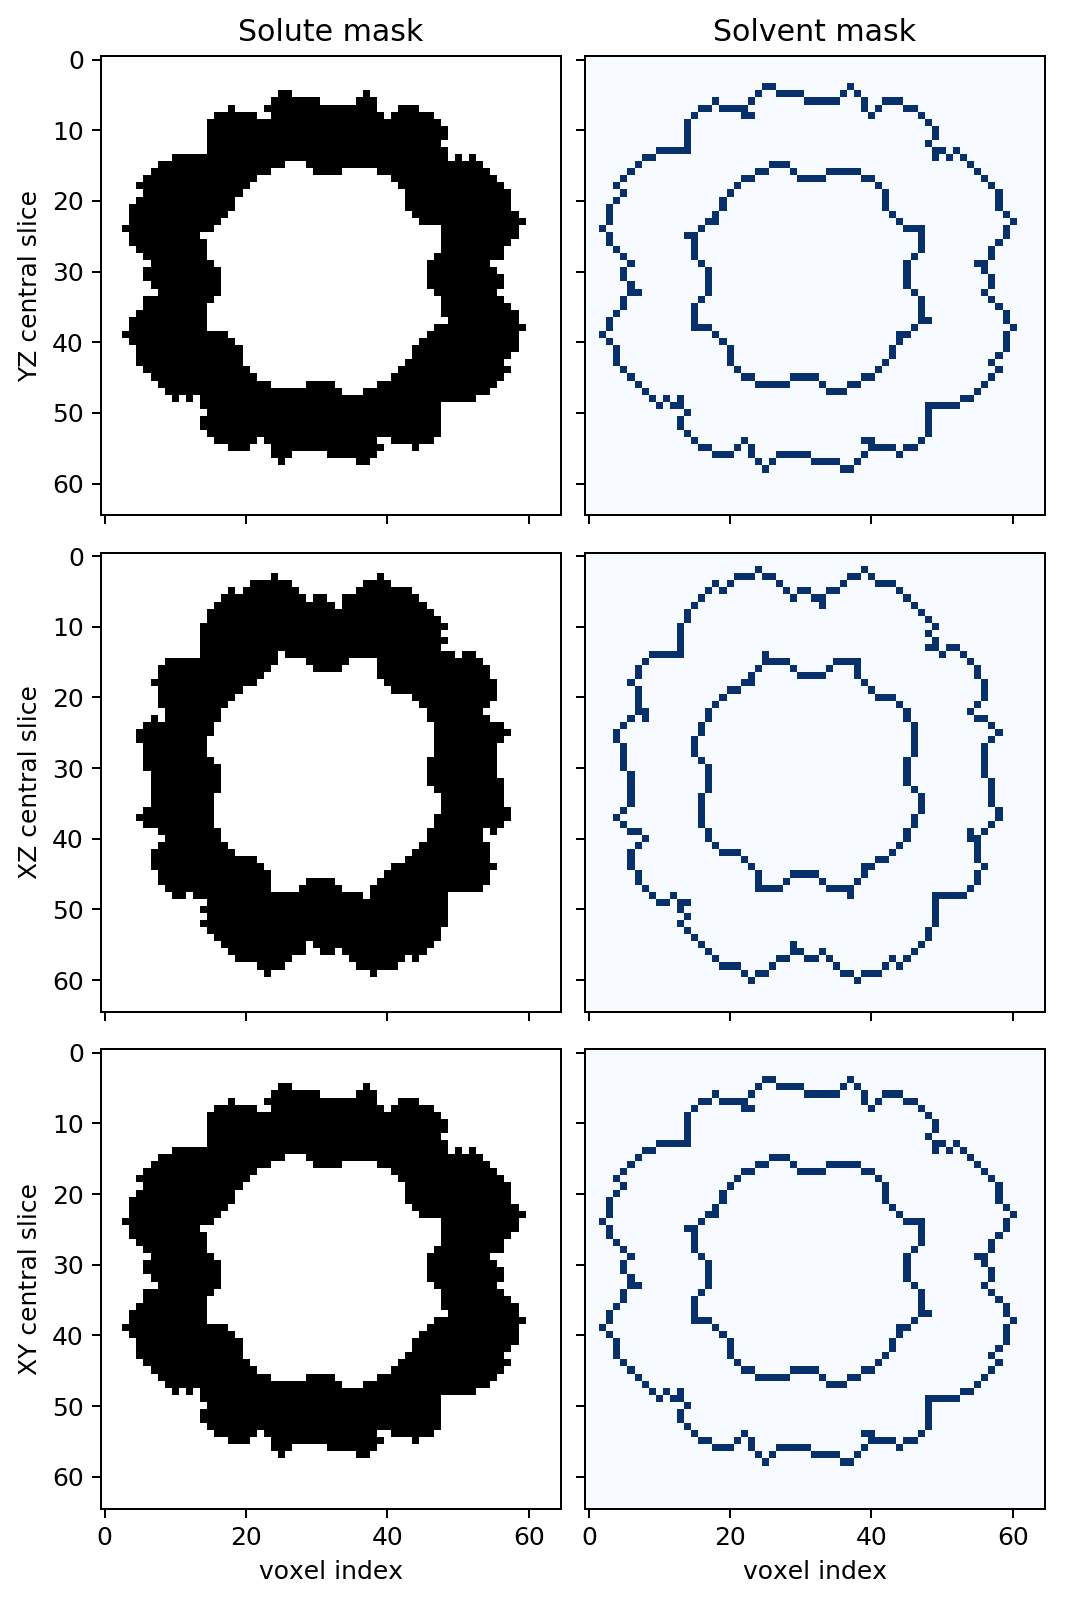

In [11]:
particle.set_hydration_layer_thickness(hydration_layer_thickness)
particle.set_mesh_voxel_size(mesh_voxel_size)
particle.create_masks()
particle.show_masks()

Let's generate a diffraction pattern of the hydrated object and visualize it

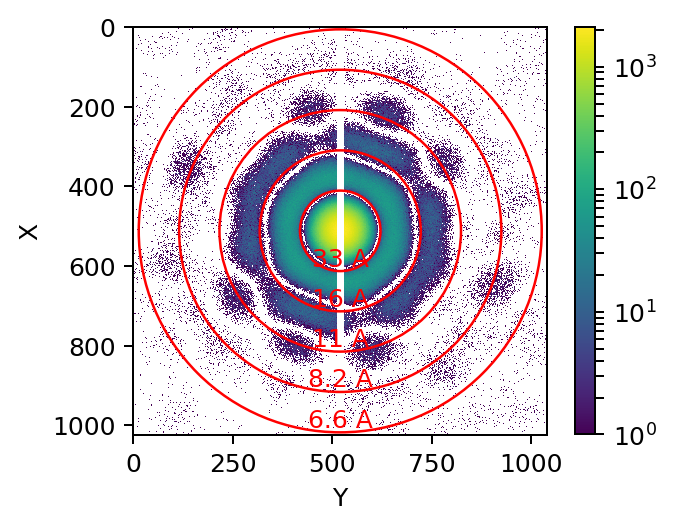

In [21]:
experiment = sk.SPIExperiment(det, beam, particle)
image = experiment.generate_image()
#
fig = plt.figure(figsize=(4,3), dpi=180)
viz = sk.Visualizer(experiment, diffraction_rings="auto", log_scale=True)
viz.imshow(image)

Let's fill the virus

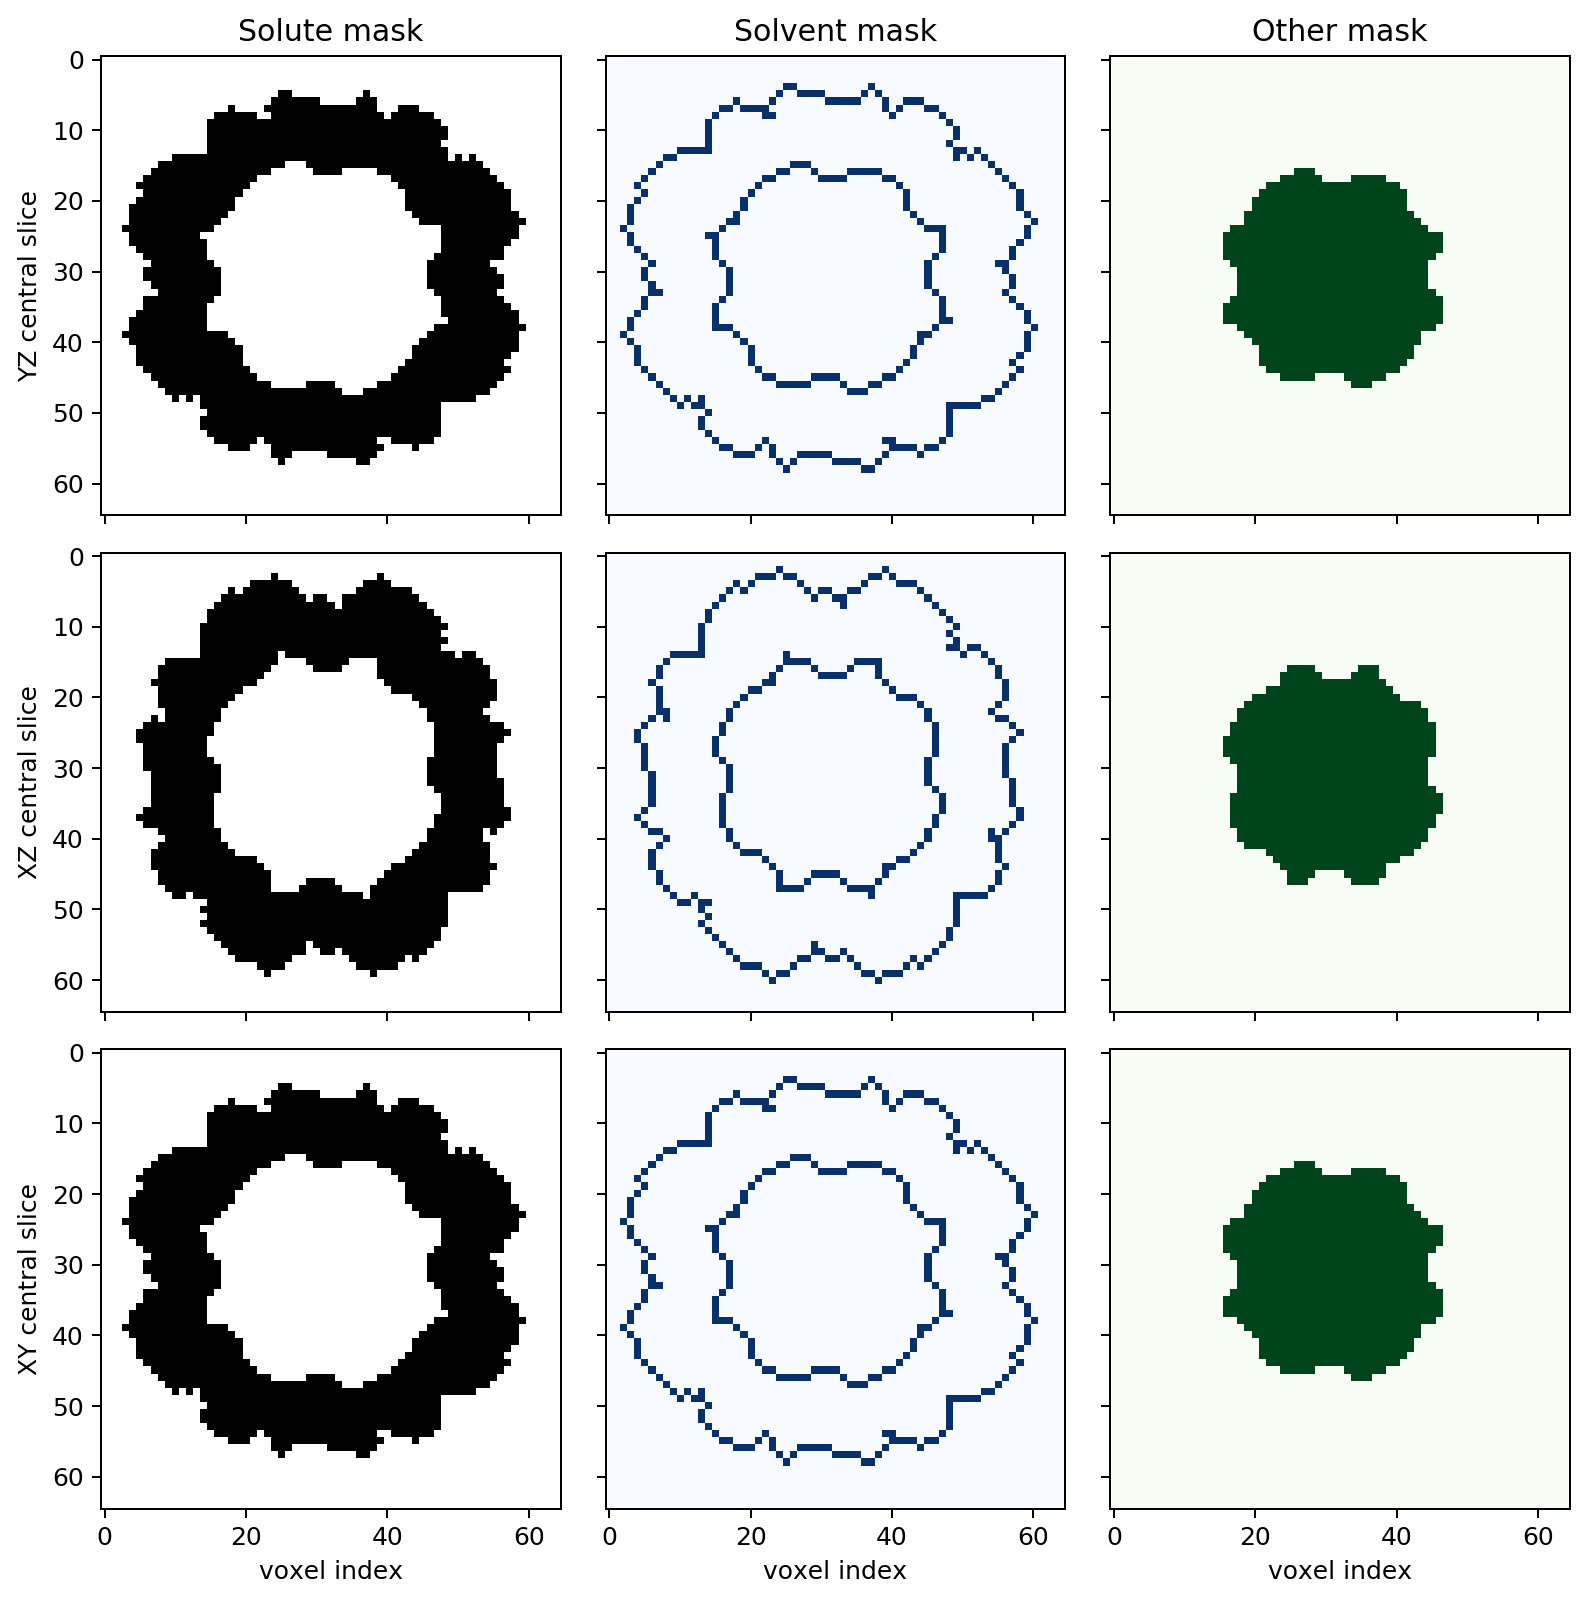

In [15]:
particle.create_other_mask(virus_void=True)
particle.show_masks()

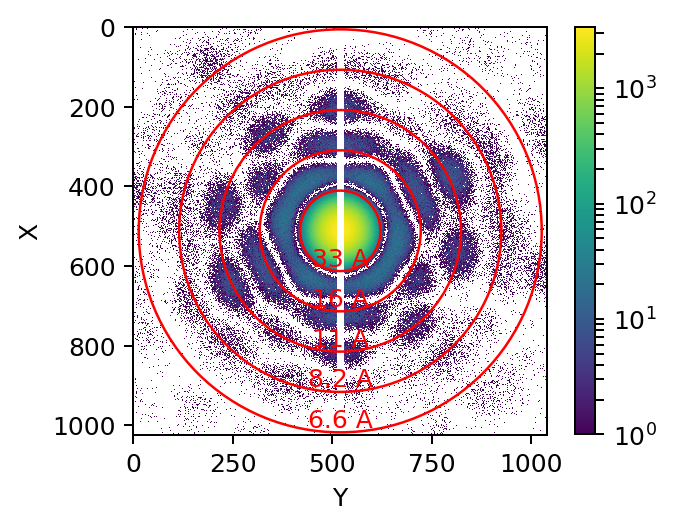

In [17]:
experiment = sk.SPIExperiment(det, beam, particle)
image = experiment.generate_image()
#
fig = plt.figure(figsize=(4,3), dpi=180)
viz = sk.Visualizer(experiment, diffraction_rings="auto", log_scale=True)
viz.imshow(image)

## Effect of mean electron density

To get a better idea of the effect of filling the inner void of the virus, let's fix the orientation of the diffraction pattern, and increase the mean electron density:

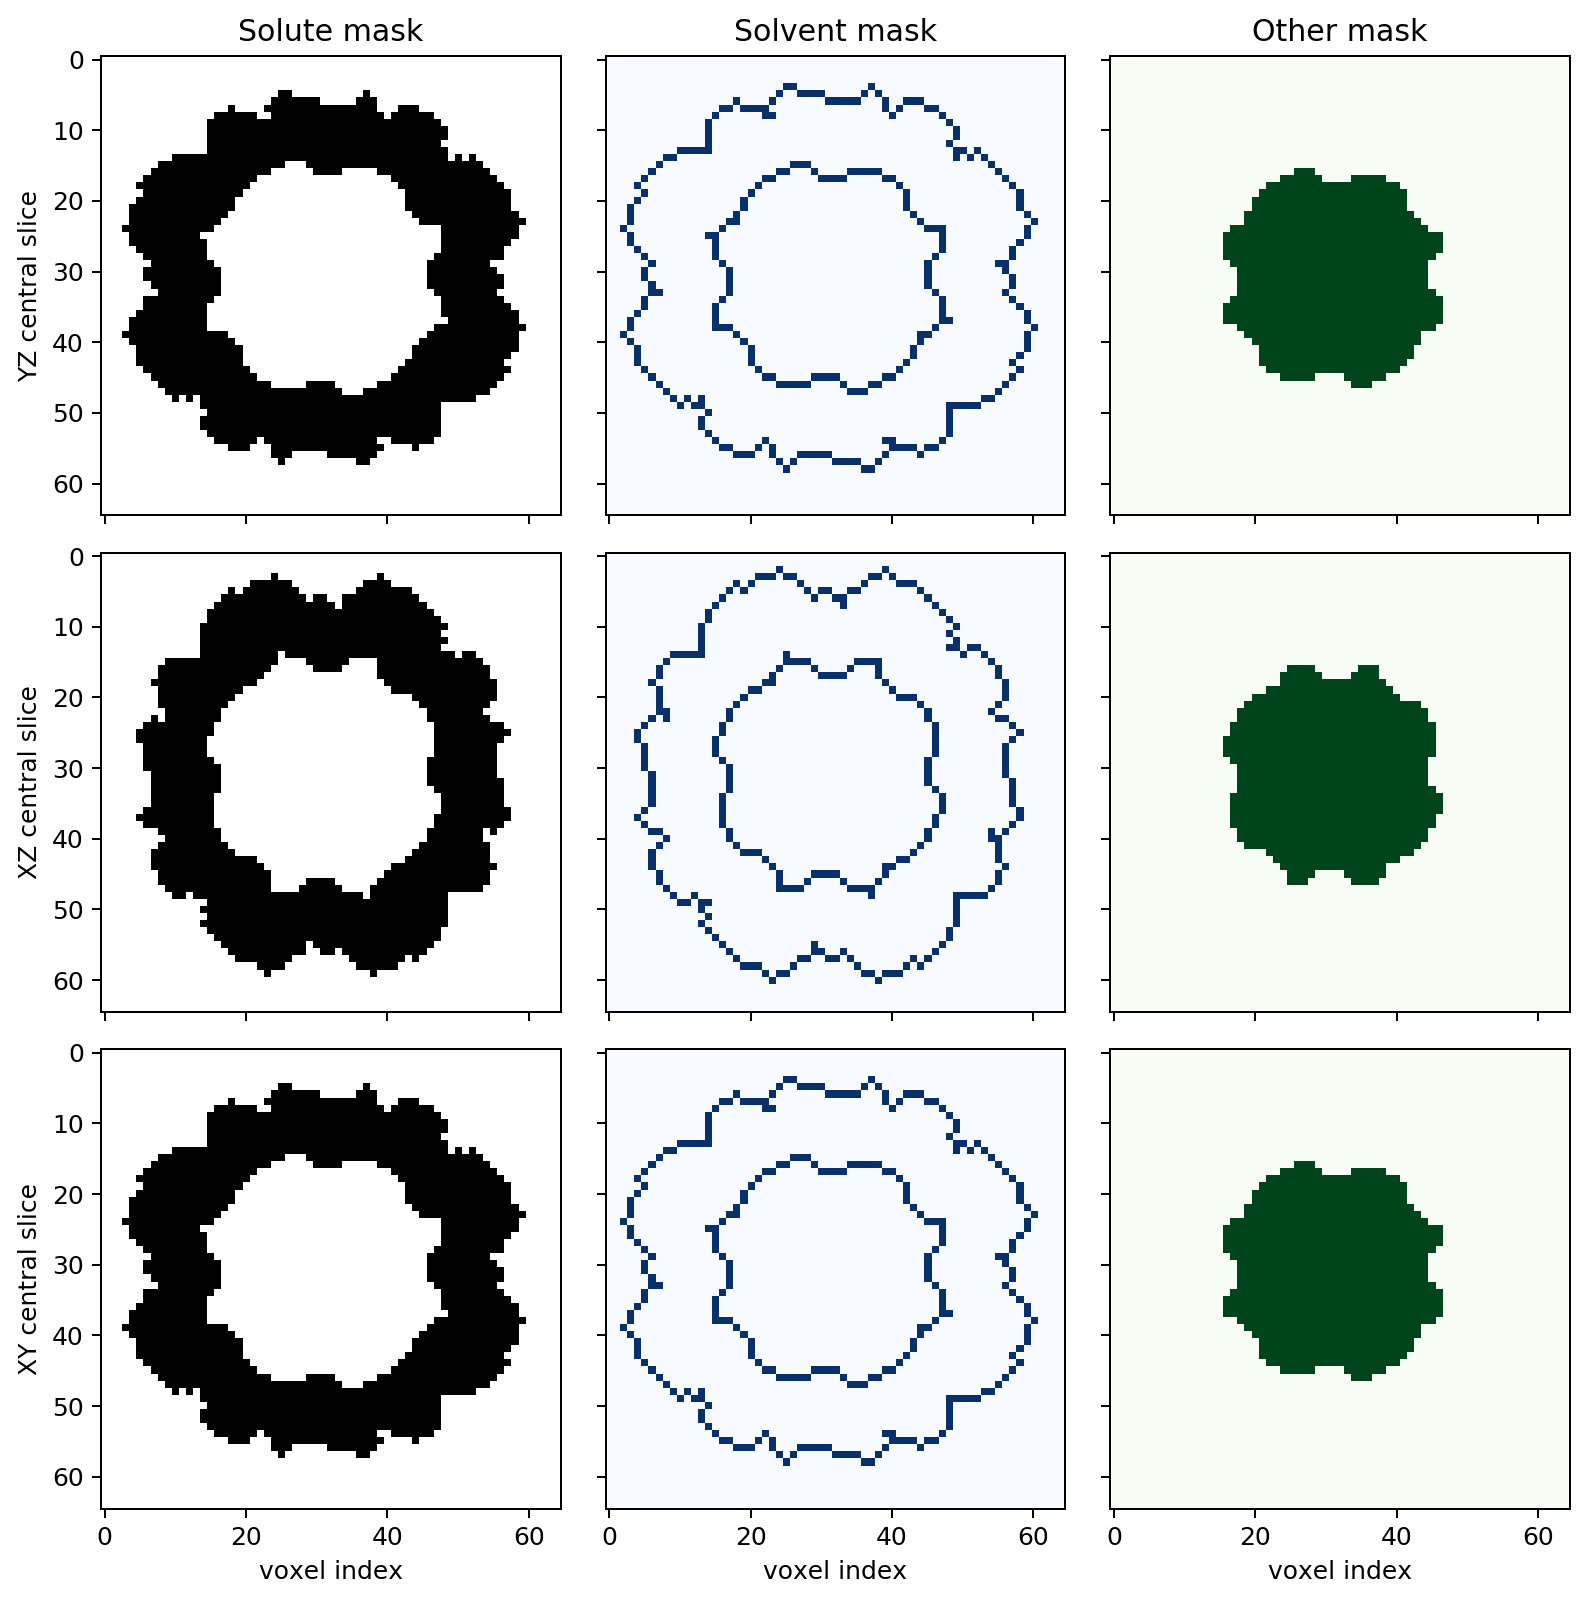

In [13]:
particle.show_masks()

Inner density = 0.0 e/A**3
Inner density = 0.15 e/A**3
Inner density = 0.3 e/A**3
Inner density = 0.45 e/A**3


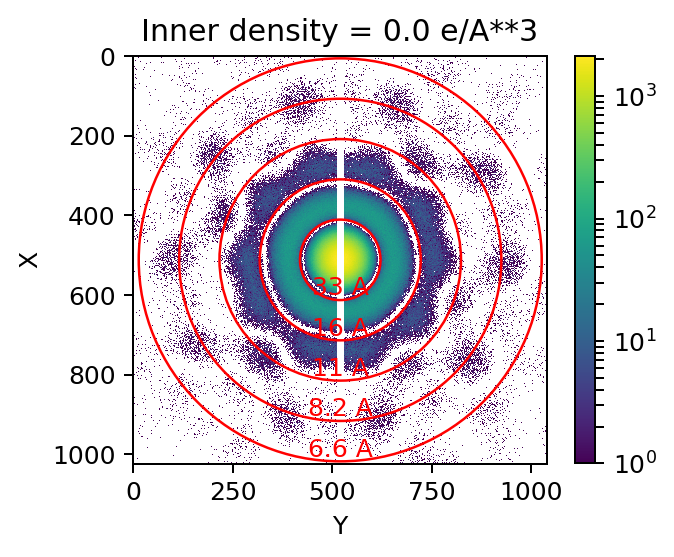

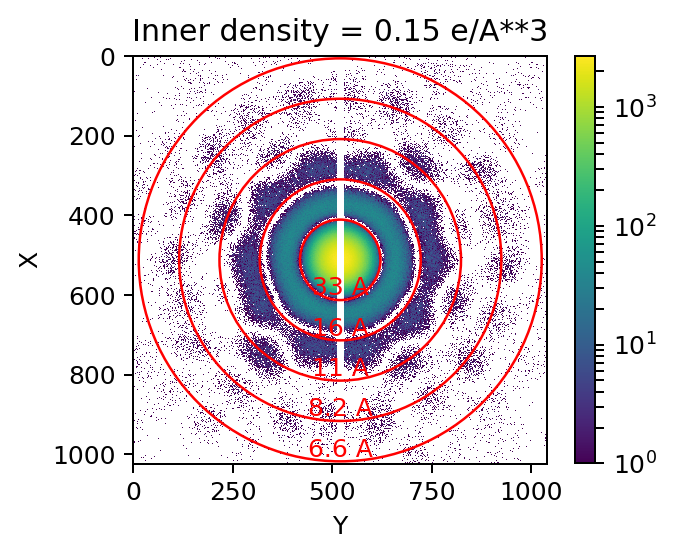

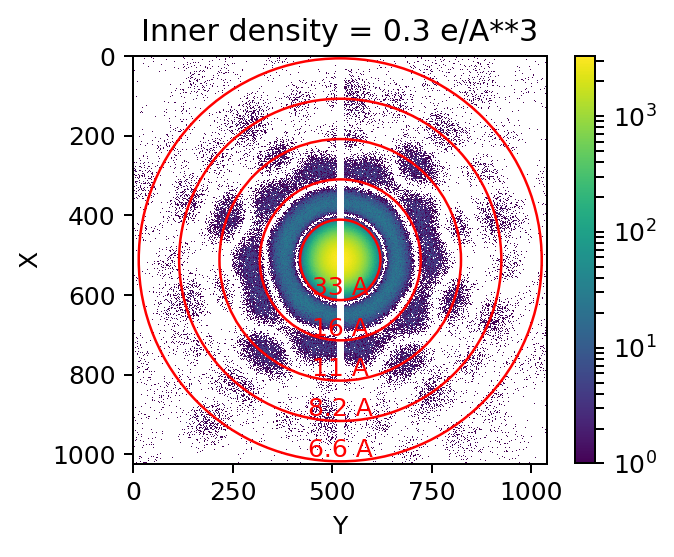

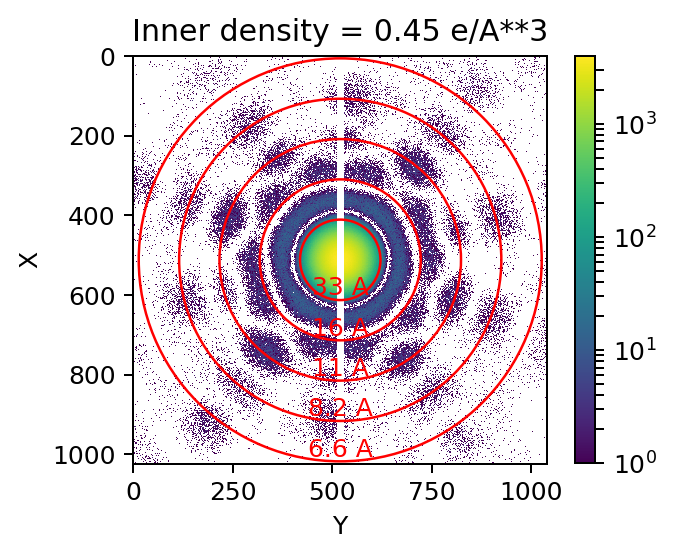

In [14]:
orientation = None 
for mean_electron_density_A in [0.0, 0.15, 0.3, 0.45]:
    print('Inner density = {} e/A**3'.format(mean_electron_density_A))
    mean_electron_density = mean_electron_density_A * 10**30
    particle.set_other_mean_electron_density(mean_electron_density)
    experiment = sk.SPIExperiment(det, beam, particle, orientations=orientation)
    if orientation is None:
        image, orientation = experiment.generate_image(return_orientation=True)
    else:
        image = experiment.generate_image()
    viz = sk.Visualizer(experiment, diffraction_rings="auto", log_scale=True)
    fig = plt.figure(figsize=(4,3), dpi=180)
    plt.title('Inner density = {} e/A**3'.format(mean_electron_density_A))
    viz.imshow(image)

## Illustrate with SAXS profile
Below we compute the radial incoherent sum of `N` particles up to `resmax` resolution, in the case where each particle is hydrated by a layer of given thickness, or not hydrated. We plot the resulting radial profiles below.

In [16]:
N = 1000000           # number of particles
resmax = 100. / 10**10  # max. resolution in meters
#
particle.set_other_mean_electron_density(0.0)
saxs_empty = sk.SAXS(particle, N, resmax)
q_empty, I_empty = saxs_empty.compute()
#
particle.set_other_mean_electron_density(0.334 * 10**30)
saxs_water_full = sk.SAXS(particle, N, resmax)
q_water_full, I_water_full = saxs_water_full.compute()

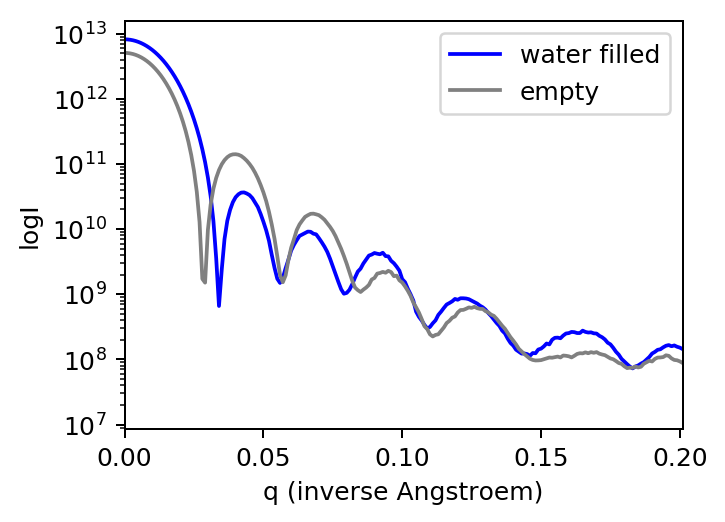

In [23]:
fig = plt.figure(figsize=(4,3),dpi=180)
plt.yscale('log')
plt.xlim(0,q_water_full[-300]/10**10)
plt.xlabel('q (inverse Angstroem)')
plt.ylabel('logI')
plt.plot(q_water_full/10**10, I_water_full, color='blue', label='water filled')
plt.plot(q_empty/10**10, I_empty, color='grey', label='empty')
plt.legend()
plt.show()

Now let's do the same without a hydration layer.

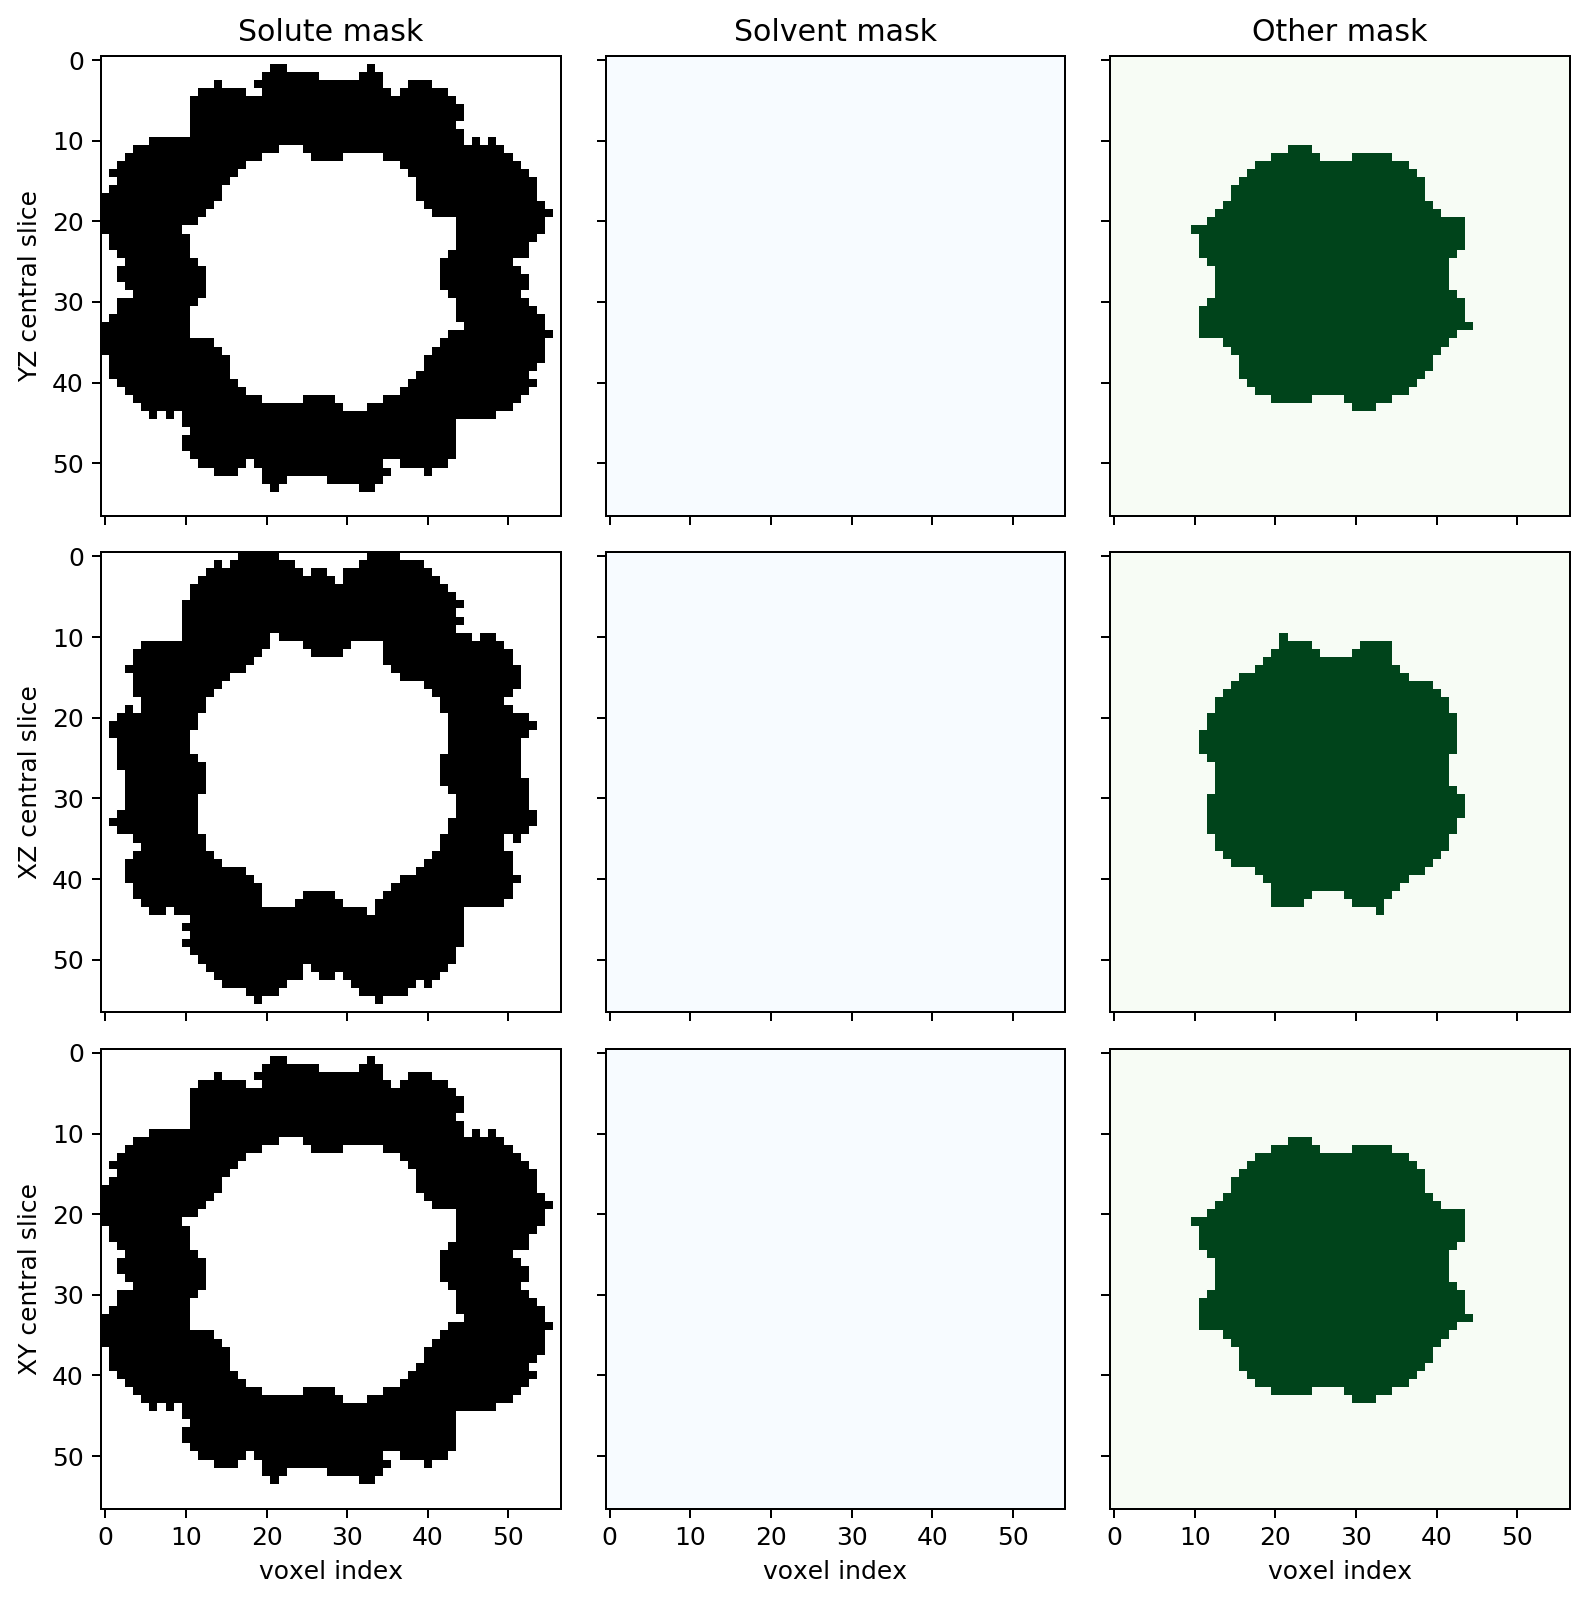

In [16]:
particle.set_hydration_layer_thickness(0.0)
particle.create_masks()
particle.create_other_mask(virus_void=True)
particle.show_masks()

In [30]:
N = 1000000           # number of particles
resmax = 2. / 10**10  # max. resolution in meters
#
particle.set_other_mean_electron_density(0.0)
saxs_empty = sk.SAXS(particle, N, resmax)
q_empty, I_empty = saxs_empty.compute()
#
particle.set_other_mean_electron_density(0.334 * 10**30)
saxs_water_full = sk.SAXS(particle, N, resmax)
q_water_full, I_water_full = saxs_water_full.compute()

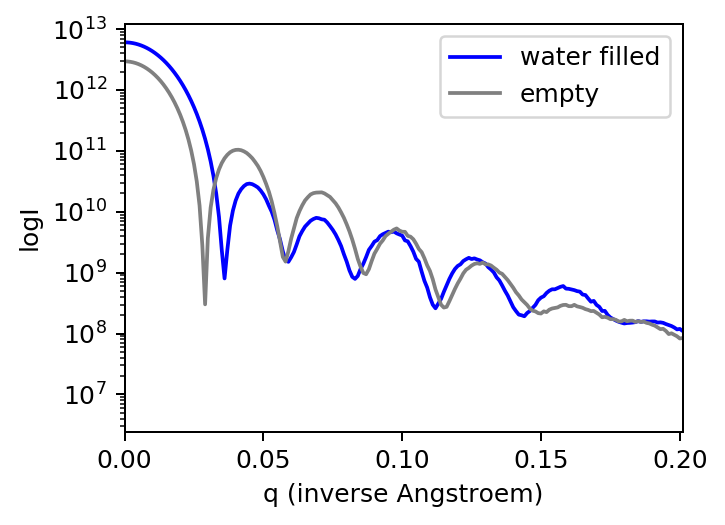

In [32]:
fig = plt.figure(figsize=(4,3),dpi=180)
plt.yscale('log')
plt.xlim(0,q_water_full[-300]/10**10)
plt.xlabel('q (inverse Angstroem)')
plt.ylabel('logI')
plt.plot(q_water_full/10**10, I_water_full, color='blue', label='water filled')
plt.plot(q_empty/10**10, I_empty, color='grey', label='empty')
plt.legend()
plt.show()